In [1]:
import torch
import matplotlib.pyplot as plt
from spectre.spectrum_general import sim_solution
from spectre.spectrum_general import element_wise
from spectre.spectrum_general import recursive_g
from spectre.spectrum_general import recursive_g_torch
from spectre.model import HR
import numpy as np
import sympy as sp


plt.rc("text", usetex=True)
plt.rc("font", family="serif")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

fileloc = r"../figures/recursive_g/"

In [2]:
# Define the system size
n = 1

# Define the diagonal rate matrix Y
Y = torch.diag(torch.rand(n))

# Define the connectivity matrix G
G = torch.randn(n, n)
G = 0.9 * G / torch.max(torch.abs(torch.linalg.eigvals(G))) # redefining the spectral radius of G to be a 0.9

In [3]:
recursive_sol = recursive_g(G=G, Y=Y)
# S_recursive = recursive_g_torch(G=G, Y=Y)

S = recursive_sol.S

In [4]:
S_brute = []
for i in range(2*n+1):
    temp = 0
    for j in range(i+1):
        temp += torch.linalg.matrix_power(G, i-j) @ Y @ torch.linalg.matrix_power(G.T, j)
    S_brute.append(temp)

In [5]:
# # ## check if the two solutions are the same
# for i in range(2*n+1):
#     print(torch.allclose(torch.from_numpy(np.array(S[i]).astype(np.float32)), S_brute[i], atol=1e-5))

### For a random network

In [60]:
def create_neural_network(N, excitatory_percent, p, g_e, g_i):
    num_excitatory = int(N * excitatory_percent)
    num_inhibitory = N - num_excitatory
    
    G = torch.zeros((N, N))
        
    # Create a list of neuron types (1 for excitatory, -1 for inhibitory)
    neuron_types = torch.cat((torch.ones(num_excitatory), -torch.ones(num_inhibitory)))
    
    # Shuffle the neuron types
    neuron_types = neuron_types[torch.randperm(N)]
    
    # Create random connections with the specified probability
    for i in range(N):
        for j in range(N):
            if np.random.rand() < p:
                if neuron_types[j] == 1:
                    G[i, j] = g_e
                else:
                    G[i, j] = g_i
    
    return G, neuron_types


N = 20  # Total number of neurons
excitatory_percent = 0.8  # 80% excitatory neurons
p = 0.1  # Probability of connection
g_e = 0.015  # Excitatory synaptic strength
g_i = -0.075  # Inhibitory synaptic strength

# define the external drive
Y = 10 * torch.eye(N)

# Find the integrated kernel matrix
G, neuron_types = create_neural_network(N, excitatory_percent, p, g_e, g_i)

# print(G)
print(neuron_types)
print(torch.count_nonzero(G) / (N**2))
print(torch.max(torch.abs(torch.linalg.eigvals(G))))

tensor([ 1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1., -1.,  1.,  1.,  1., -1.])
tensor(0.0825)
tensor(0.0351)


In [61]:
n_max = 2 * N + 1
# n_max = 20
recursive_sol = recursive_g(G=G, Y=Y, n_max=n_max)
S = recursive_sol.S

In [62]:
# for sympy
c = [0] * n_max

for idx, mat in enumerate(S):
    c[idx] = float(sum(mat).evalf()) / (N * N)
    # c[idx] = c[idx] / (idx + 1)

# convert c to numpy array
c = np.array(c)

In [63]:
# for torch
recursive_sol_torch = recursive_g_torch(G=G, Y=Y, n_max=n_max)
S_torch = recursive_sol_torch.S

c_torch = [0] * n_max

for idx, mat in enumerate(S_torch):
    c_torch[idx] = torch.sum(mat).item() / (N * N)
    # c_torch[idx] = c_torch[idx] / (idx + 1)

# convert c to numpy array
c_torch = np.array(c_torch)

In [64]:
# brute force
c_brute = [0] * n_max

for i in range(n_max):
    mat = 0
    for j in range(i+1):
        mat += torch.linalg.matrix_power(G, i-j) @ Y @ torch.linalg.matrix_power(G.T, j)
    c_brute[i] = torch.sum(mat).item() / (N * N)
    # c_brute[i] = c_brute[i] / (i + 1)

c_brute = np.array(c_brute)

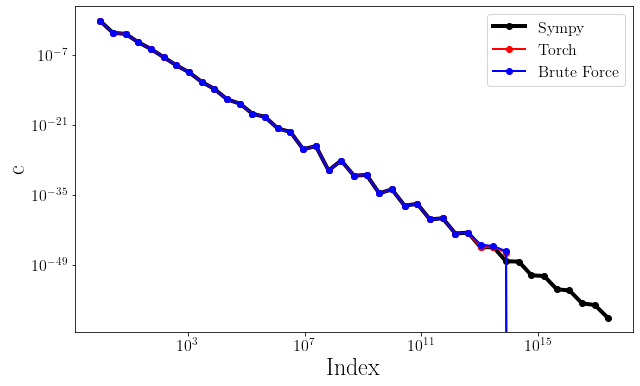

In [65]:
from matplotlib.ticker import MaxNLocator, LogLocator

plt.figure(figsize=(10, 6))
x = np.exp(np.arange(n_max))
plt.plot(x, abs(c), 'o-', color='k', linewidth=4, label='Sympy')
plt.plot(x, abs(c_torch), 'o-', color='r', linewidth=2, label='Torch')
plt.plot(x, abs(c_brute), 'o-', color='b', linewidth=2, label='Brute Force')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Index', fontsize=24)
plt.ylabel('c', fontsize=24)
plt.legend(fontsize=16)

# Adjusting tick parameters
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Customizing the number of ticks for logarithmic scale
plt.gca().xaxis.set_major_locator(LogLocator(base=10.0, numticks=5))
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, numticks=5))

plt.show()

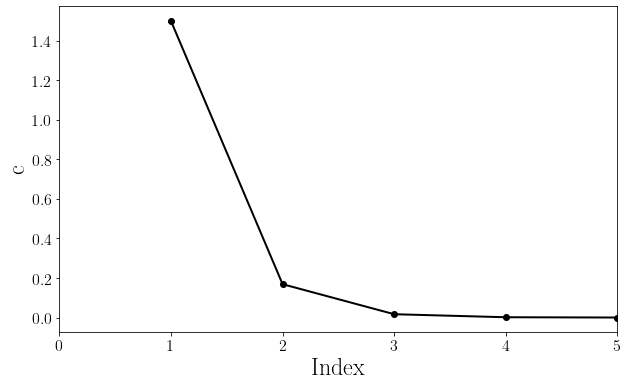

In [22]:
# plot lin lin
plt.figure(figsize=(10, 6))
x = np.arange(n_max)
plt.plot(x[1:], abs(c[1:]), 'o-', color='k', linewidth=2)
plt.xlim([0, 5])
plt.xlabel('Index', fontsize=24)
plt.ylabel('c', fontsize=24)

# Adjusting tick parameters
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

### We do the same for structured network, where the connectivity is only limited to a distance d


In [29]:
import torch
import numpy as np

def create_neural_network_local(N, excitatory_percent, d, g_e, g_i):
    num_excitatory = int(N * excitatory_percent)
    num_inhibitory = N - num_excitatory
    
    G = torch.zeros((N, N))
        
    # Create a list of neuron types (1 for excitatory, -1 for inhibitory)
    neuron_types = torch.cat((torch.ones(num_excitatory), -torch.ones(num_inhibitory)))
    
    # Shuffle the neuron types
    neuron_types = neuron_types[torch.randperm(N)]
    
    # Create connections limited to nearby neighbors within distance d
    for i in range(N):
        for j in range(i - d, i + d + 1):
            j_mod = j % N  # Wrap around for the ring structure
            if neuron_types[j_mod] == 1:
                G[i, j_mod] = g_e
            else:
                G[i, j_mod] = g_i
    
    return G, neuron_types


N = 15  # Total number of neurons
excitatory_percent = 0.8  # 80% excitatory neurons
d = 3  # Distance within which connections are allowed
g_e = 0.015  # Excitatory synaptic strength
g_i = -0.075  # Inhibitory synaptic strength

# define the external drive
Y = 10 * torch.eye(N)

# Find the integrated kernel matrix
G, neuron_types = create_neural_network_local(N, excitatory_percent, d, g_e, g_i)

print(neuron_types)
print(torch.count_nonzero(G) / (N**2))
print(torch.max(torch.abs(torch.linalg.eigvals(G))))


tensor([ 1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
        -1.])
tensor(0.4667)
tensor(0.0808)


Text(0, 0.5, 'Neuron index')

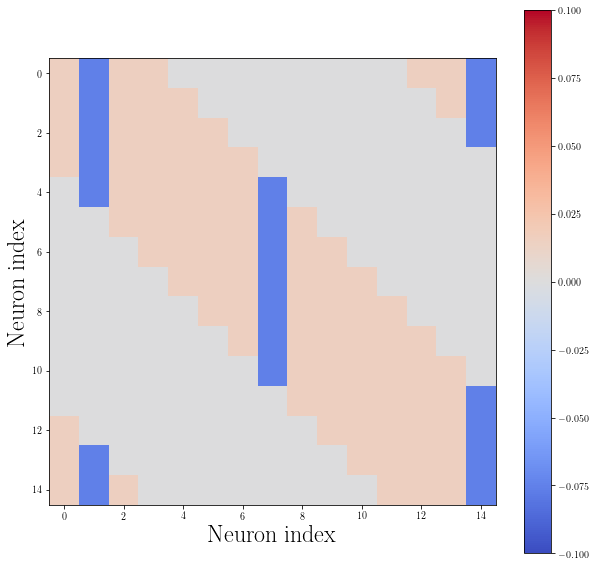

In [30]:
# plot G with a diverging colormap
plt.figure(figsize=(10, 10))
plt.imshow(G, cmap='coolwarm', vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.xlabel('Neuron index', fontsize=24)
plt.ylabel('Neuron index', fontsize=24)


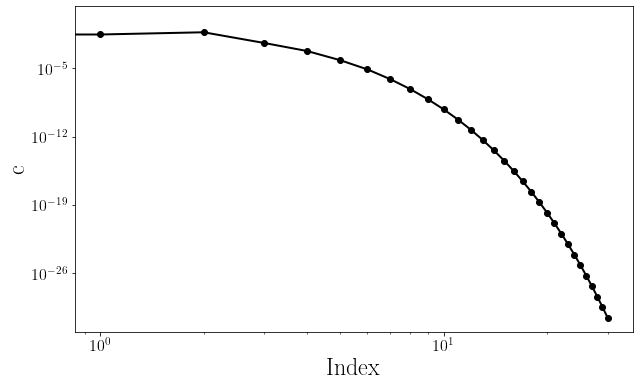

In [32]:
n_max = 2 * N + 1
recursive_sol = recursive_g(G=G, Y=Y, n_max=n_max)
S = recursive_sol.S

# create an empty list of size n_max
c = [0] * n_max

for idx, mat in enumerate(S):
    c[idx] = float(sum(mat).evalf()) / (N * N)
    # c[idx] = c[idx] / (idx + 1)

# convert c to numpy array
c = np.array(c)

from matplotlib.ticker import MaxNLocator, LogLocator

plt.figure(figsize=(10, 6))
x = np.arange(2 * N + 1)
plt.plot(x, abs(c), 'o-', color='k', linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Index', fontsize=24)
plt.ylabel('c', fontsize=24)

# Adjusting tick parameters
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Customizing the number of ticks for logarithmic scale
plt.gca().xaxis.set_major_locator(LogLocator(base=10.0, numticks=5))
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, numticks=5))

plt.show()